In [1]:
from neo_access import *
from get_response_prop import *
#from get_response_prop import calculate_bandwidth,response_detection_core#,build_pdf
import numpy as np
import matplotlib.pyplot as plt
from neo.io import PickleIO
import pandas as pd
import os

In [2]:
wd = 'D:/Work/Recordings/DATA/Neuropixel/190628/2019-06-28_09-27-20/SpikeSortingResults'
trials = 20
sweeplength = 22
samplerate = 30000



os.chdir(wd)
io = PickleIO(filename="vpl_block_20190628.pkl")
blk2 = io.read()[0]
dataframe = pd.read_pickle(os.path.join(wd,'vpl_block_df_20190628.pkl'))





In [3]:
expID = '002_'
sweep_Id = 0.0

selection_tmp = dataframe[(dataframe['expID'] == expID)& (dataframe['sweep_Id'] == sweep_Id)]
data = get_all_data(blk2,selection_tmp,raster=True,timestamps=False,spikes=False,aisignal=False)

In [4]:
neurons_num = len(data[0])
trials_num = 20
signal_len = int(selection_tmp['sweeplength'][0]*30000)
time = np.linspace(0, 20, signal_len)



# bin data

binsize= 0.01*30000
bins = np.arange(0,signal_len,binsize)
time_bin = np.linspace(0, 20, bins.size-1)
dat = np.zeros((neurons_num,trials_num,bins.size-1))

print('Data Dimensions are: {} x {} x {}'.format(neurons_num, trials_num, bins.size-1))

Data Dimensions are: 359 x 20 x 2199


In [5]:
for clu in range(neurons_num):
    clu = int(clu)
    for tr in range(trials_num):
        tr = int(tr)
        
        x,y = np.histogram((data[0][clu][:,0][(data[0][clu][:,1]== tr)]).astype(int),bins=bins)
        dat[clu,tr,:] = x

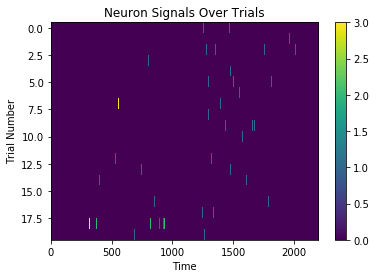

In [6]:
# Plot example of one neuron
signal = (dat[5][:]).astype(float)
plt.imshow(signal, aspect = 'auto')
plt.xlabel('Time')
plt.ylabel('Trial Number')
plt.title('Neuron Signals Over Trials')
#plt.xlim(900,1500)
#plt.ylim(0,3)
plt.colorbar()
plt.show()

In [7]:
time.shape

(660000,)

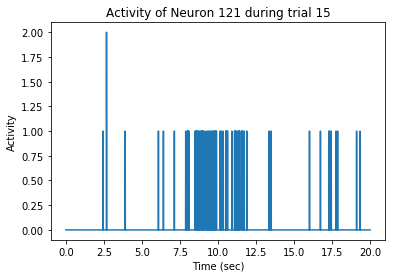

In [8]:
neuron = 120
trial = 14
signal1 = dat[neuron, trial, :]
plt.plot(time_bin, signal1)
plt.title('Activity of Neuron ' + str(neuron + 1) + ' during trial ' + str(trial + 1))
plt.xlabel('Time (sec)')
plt.ylabel('Activity')
plt.show()

In [9]:
# Create a Signal Matrix where each signal is put into a column
signals_all = np.zeros([bins.size-1, trials_num*neurons_num])
k = 0
for n in np.arange(neurons_num):
    for m in np.arange(trials_num):
        signals_all[:, k] = dat[n][m][:]
        k = k+1

In [10]:
# Mean center signal matrix
means = np.mean(signals_all, axis = 0)
signals_mcen = signals_all-means
signals_mcen = signals_mcen*(1/((np.shape(signals_mcen)[0]-1)))  

In [11]:
# apply SVD
import numpy.linalg as la
u,s,vh = la.svd(signals_mcen, full_matrices=False)
v = np.transpose(vh)

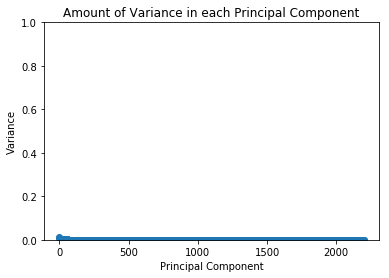

In [12]:
# Plot variance in PCs, we do not see a significant principal component in this case
plt.scatter(np.arange(len(s)), s**2/np.sum(s**2))
plt.ylim([0, 1])
plt.title('Amount of Variance in each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.show()

In [13]:
# Average the activity for all trials for each neuron
Activity_avg = np.zeros([neurons_num, bins.size-1])
for n in np.arange(neurons_num):
    aavg = np.zeros([1, bins.size-1])
    for m in np.arange(trials_num):
        aavg = aavg + dat[n][m][:]
    aavg = (1/trials_num)*aavg
    Activity_avg[n] = aavg

# Mean Center
means = np.mean(Activity_avg, axis = 0)
signals_mcen = Activity_avg-means
signals_mcen = signals_mcen*(1/((np.shape(signals_mcen)[0]-1)))  

# apply SVD
u,s,vh = la.svd(signals_mcen, full_matrices=False)
v = np.transpose(vh)

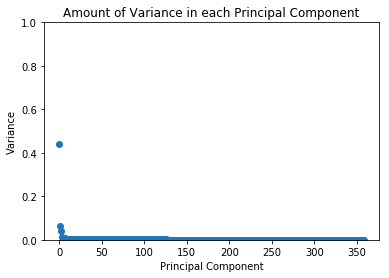

In [14]:
# Plot variance in PCs, we see more variance in this case
plt.scatter(np.arange(len(s)), s**2/np.sum(s**2))
plt.ylim([0, 1])
plt.title('Amount of Variance in each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.show()

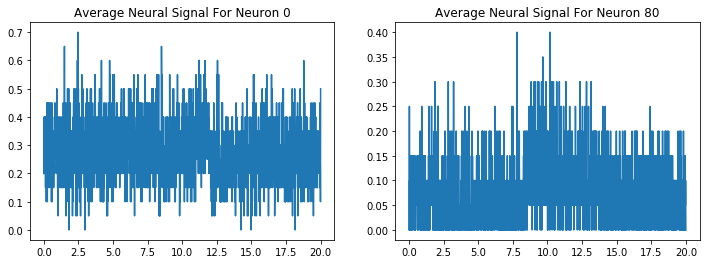

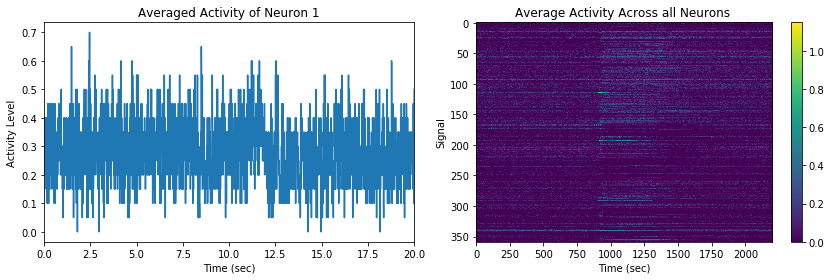

In [15]:
# Average activity for 0 and 80 are pretty different looking
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time_bin, Activity_avg[0])    
ax[0].set_title('Average Neural Signal For Neuron 0')
ax[1].plot(time_bin, Activity_avg[80])    
ax[1].set_title('Average Neural Signal For Neuron 80')

# Create Spectrogram of Averaged signal 
width = 0.01
timeslide = np.arange(0,80, 0.1)
spc = np.zeros([len(timeslide), bins.size-1])
k = 0
n_num = 0
signal1 = Activity_avg[n_num]
for ts in timeslide:
    fil = np.exp(-width*(time_bin-ts)**10)
    fs = signal1*fil
    fst = np.fft.fft(fs)
    spc[k,:] = np.abs(np.fft.fftshift(fst))
    k = k+1

x2 = np.arange((-bins.size-1)/2, 0)
x1 = np.arange(0, (bins.size-1)/2)
kk = np.concatenate((x1, x2))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time_bin, signal1)
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Activity Level')
ax[0].set_title('Averaged Activity of Neuron ' + str(n_num + 1))
ax[0].set_xlim([0, 20])
im = ax[1].imshow(Activity_avg, aspect='auto')
ax[1].set_title('Average Activity Across all Neurons ')
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Signal')
plt.tight_layout()
plt.colorbar(im, ax=ax[1])
plt.show()

In [16]:
neuron_delete_ind = []
for i_neuron in range(Activity_avg.shape[0]):
    s = np.sum(Activity_avg[i_neuron,:])
    if s < 20:
        neuron_delete_ind.append(i_neuron)

In [17]:
data_ave_cleared = np.delete(Activity_avg, neuron_delete_ind, 0)

In [18]:
data_ave_cleared.shape

(281, 2199)

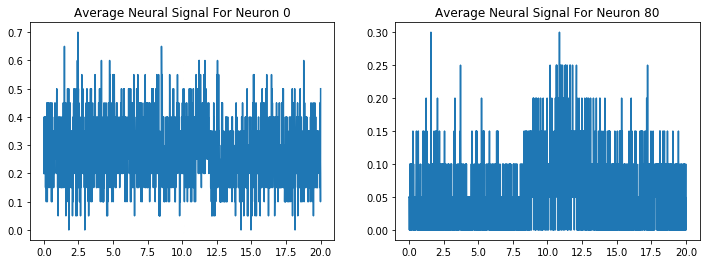

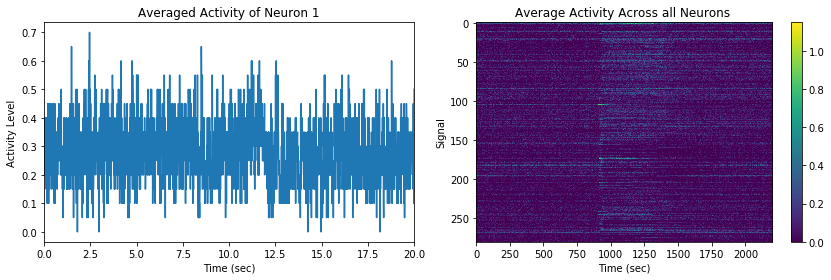

In [19]:
# Average activity for 0 and 80 are pretty different looking
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time_bin, data_ave_cleared[0])    
ax[0].set_title('Average Neural Signal For Neuron 0')
ax[1].plot(time_bin, data_ave_cleared[80])    
ax[1].set_title('Average Neural Signal For Neuron 80')

# Create Spectrogram of Averaged signal 
width = 0.01
timeslide = np.arange(0,80, 0.1)
spc = np.zeros([len(timeslide), bins.size-1])
k = 0
n_num = 0
signal1 = data_ave_cleared[n_num]
for ts in timeslide:
    fil = np.exp(-width*(time_bin-ts)**10)
    fs = signal1*fil
    fst = np.fft.fft(fs)
    spc[k,:] = np.abs(np.fft.fftshift(fst))
    k = k+1

x2 = np.arange((-bins.size-1)/2, 0)
x1 = np.arange(0, (bins.size-1)/2)
kk = np.concatenate((x1, x2))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time_bin, signal1)
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Activity Level')
ax[0].set_title('Averaged Activity of Neuron ' + str(n_num + 1))
ax[0].set_xlim([0, 20])
im = ax[1].imshow(data_ave_cleared, aspect='auto')
ax[1].set_title('Average Activity Across all Neurons ')
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Signal')
plt.tight_layout()
plt.colorbar(im, ax=ax[1])
plt.show()

In [20]:
# z-score the data 
from scipy import stats

data_zscored = 0*data_ave_cleared
for i_neuron in range(data_ave_cleared.shape[0]):
    data_zscored[i_neuron,:] = stats.zscore(data_ave_cleared[i_neuron,:])

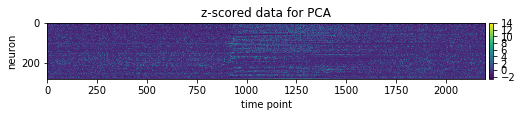

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(8,5))
ax = plt.gca()
im = ax.imshow(data_zscored)
plt.xlabel('time point')
plt.ylabel('neuron')
plt.title('z-scored data for PCA')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [22]:
# SVD the data matrix 
u, s, vh = np.linalg.svd(data_zscored, full_matrices=False)

In [23]:
def plot_s(s):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(7,3))

    ax1.plot(s)
    ax1.set_xlabel('i')
    ax1.set_ylabel('sigma_i')
    ax1.set_title('singular values')

    # get variance
    variance_list = []
    for i in range(len(s)):
        variance_list.append(s[i]**2/np.sum(s**2))
    
    ax2.plot(variance_list, 'o-')
    ax2.set_xlabel('principal component')
    ax2.set_ylabel('% variance')
    ax2.set_title('% variance')
    
    ax3.plot(variance_list[:10], 'o-')
    ax3.set_xlabel('principal component')
    ax3.set_ylabel('% variance')
    ax3.set_title('% var for first 3 PC')

In [24]:
plot_s(s)

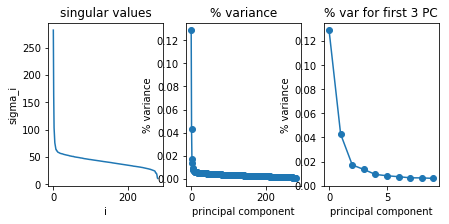

In [25]:
plt.show()

In [26]:
PC3 = np.zeros((3, data_zscored.shape[1]))
for i in range(3):
    PC3[i,:] = vh[i,:]*s[i]

<IPython.core.display.Javascript object>


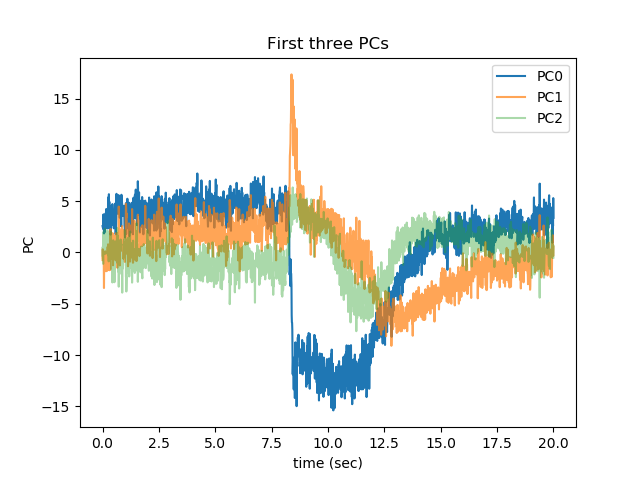

In [27]:
%matplotlib notebook
plt.figure()
for i in range(3):
    plt.plot(time_bin, PC3[i, :], alpha=1.0-0.3*i, label='PC'+str(i))
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('PC')
plt.title('First three PCs')
plt.show()

<IPython.core.display.Javascript object>


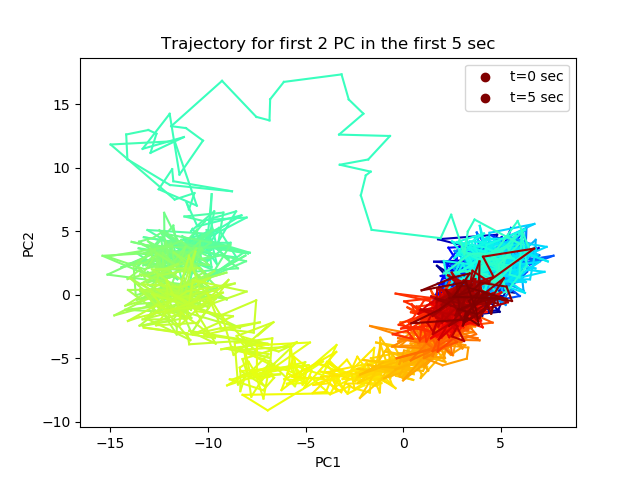

In [28]:
t_start = 0
t_end = 2199

x = PC3[0,t_start:t_end]
y = PC3[1,t_start:t_end]

#x = PC3[0,:]

#y = PC3[1,:]
n = len(x)

# Your colouring array
colors = plt.cm.jet(np.linspace(0,1,np.size(x)))
fig = plt.figure()
ax = fig.add_subplot(111)

# Segement plot and colour depending on T
s = 1 # Segment length
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1],y[i:i+s+1],color=colors[i])
ax.scatter(x[0], y[0], label='t=0 sec', color=colors[i])
ax.scatter(x[-1], y[-1], label='t=5 sec', color=colors[i])
plt.title('Trajectory for first 2 PC in the first 5 sec')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

In [29]:
PC3.shape

(3, 2199)

<IPython.core.display.Javascript object>


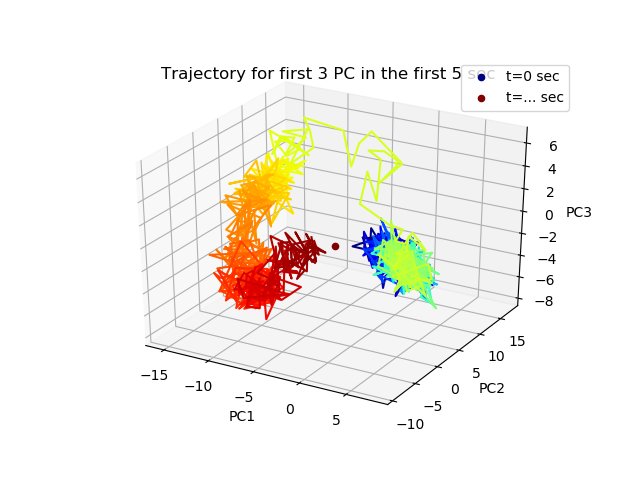

Text(0.5,0.92,'Trajectory for first 3 PC in the first 5 sec')

In [30]:
from mpl_toolkits.mplot3d import Axes3D

t_start = 0
t_end = 1499
fig = plt.figure()
ax = fig.gca(projection='3d')

x = PC3[0,t_start:t_end]
colors = plt.cm.jet(np.linspace(0,1,np.size(x)))
s = 10 # Segment length
n = len(x)
for i in range(0,n-s,s):
    ax.plot(PC3[0,i:i+s+1], PC3[1,i:i+s+1], PC3[2,i:i+s+1], color=colors[i])
ax.scatter(PC3[0,t_start], PC3[1,t_start], PC3[2,t_start], label='t=0 sec', color=colors[0])#(0.0,0.5,T[0]))
ax.scatter(PC3[0,t_end-t_start-1], PC3[1,t_end-t_start-1], PC3[2,t_end-t_start-1], label='t=... sec', color=colors[-1])
plt.legend()

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Trajectory for first 3 PC in the first 5 sec')

In [31]:
def plot_s(s):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(7,3))

    ax1.plot(s)
    ax1.set_xlabel('i')
    ax1.set_ylabel('sigma_i')
    ax1.set_title('singular values')

    # get variance
    variance_list = []
    for i in range(len(s)):
        variance_list.append(s[i]**2/np.sum(s**2))
    
    ax2.plot(variance_list, 'o-')
    ax2.set_xlabel('principal component')
    ax2.set_ylabel('% variance')
    ax2.set_title('% variance')
    
    ax3.plot(variance_list[:10], 'o-')
    ax3.set_xlabel('principal component')
    ax3.set_ylabel('% variance')
    ax3.set_title('% var for first 10 PC')
    
def data_plot(data):
    # SVD the data matrix 
    u, s, vh = np.linalg.svd(data, full_matrices=False)
    
    plot_s(s)
    
    PC3 = np.zeros((3, data.shape[1]))
    for i in range(3):
        PC3[i,:] = vh[i,:]*s[i]
        
    return PC3

def plot_PC3(PC3):
    plt.figure()
    l = PC3.shape[1]
    time = np.arange(0,81,81/l)
    for i in range(3):
        plt.plot(time, PC3[i, :], alpha=1.0-0.3*i, label='PC'+str(i))
    plt.legend()
    plt.xlabel('time (sec)')
    plt.ylabel('PC')
    plt.title('First three PCs')

def plot_PC_1(PC3, t_end=150):
    t_start = 0

    x = PC3[0,t_start:t_end]
    y = PC3[1,t_start:t_end]
    n = len(x)

    # Your colouring array
    T=np.linspace(0,1,np.size(x))**2
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Segement plot and colour depending on T
    s = 10 # Segment length
    for i in range(0,n,s):
        ax.plot(x[i:i+s+1],y[i:i+s+1],color=(0.0,0.5,T[i]))
    ax.scatter(x[0], y[0], label='t=0 sec', color=(0.0,0.5,T[0]))
    ax.scatter(x[-1], y[-1], label='t=5 sec', color=(0.0,0.5,T[-1]))
    plt.title('Trajectory for first 2 PC in the first 5 sec')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()

def plot_PC_02(PC3, t_end=150):
    t_start = 0
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    x = PC3[0,t_start:t_end]
    n = len(x)
    T=np.linspace(0,1,np.size(x))**2
    s = 10 # Segment length
    for i in range(0,n,s):
        ax.plot(PC3[0,i:i+s+1], PC3[1,i:i+s+1], PC3[2,i:i+s+1], color=(0.0,0.5,T[i]))
    ax.scatter(PC3[0,t_start], PC3[1,t_start], PC3[2,t_start], label='t=0 sec', color=(0.0,0.5,T[0]))
    ax.scatter(PC3[0,t_end-t_start-1], PC3[1,t_end-t_start-1], PC3[2,t_end-t_start-1], label='t=5 sec', color=(0.0,0.5,T[-1]))
    plt.legend()

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Trajectory for first 3 PC in the first 5 sec')

def plot_all_PC(data_file, t_end) :
    data = data_file
    PC3 = data_plot(data)
    plot_PC3(PC3)
    plot_PC_1(PC3, t_end)
    plot_PC_02(PC3, t_end)
    
    """run_zed = run_zed.reshape((len(PC3[0,:]), -1))
    run_zed = np.mean(run_zed, 1)
    for i in range(3):
        cov = pearsonr(run_zed, PC3[i,:])[0]
        print('PC'+str(i)+': '+str(cov))"""

<IPython.core.display.Javascript object>


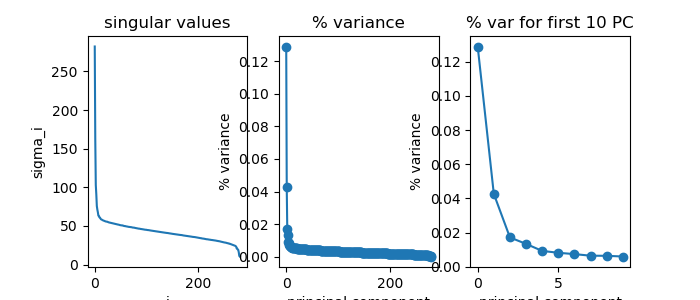

<IPython.core.display.Javascript object>


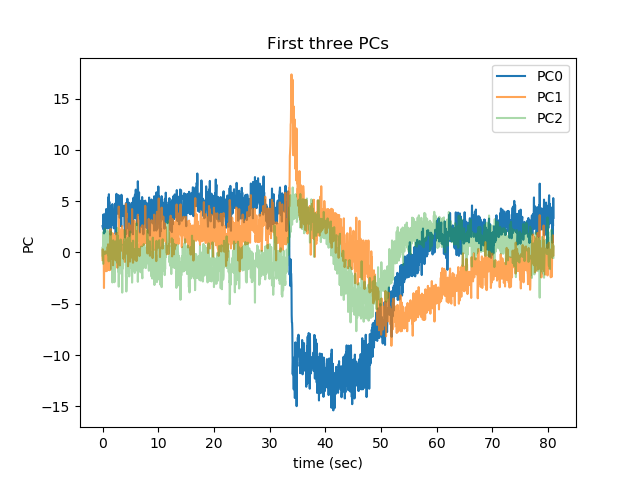

<IPython.core.display.Javascript object>


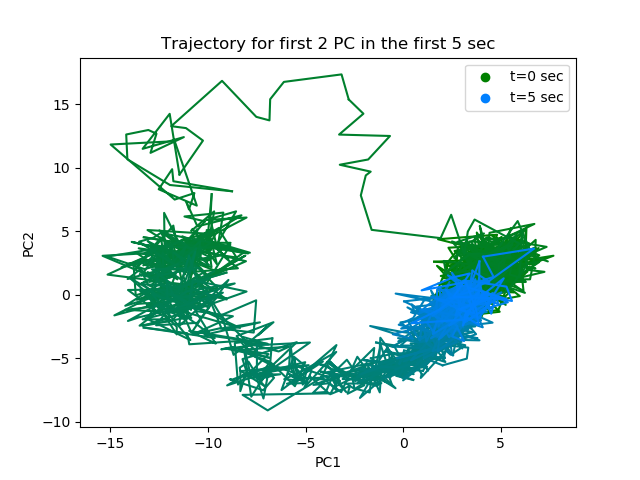

<IPython.core.display.Javascript object>


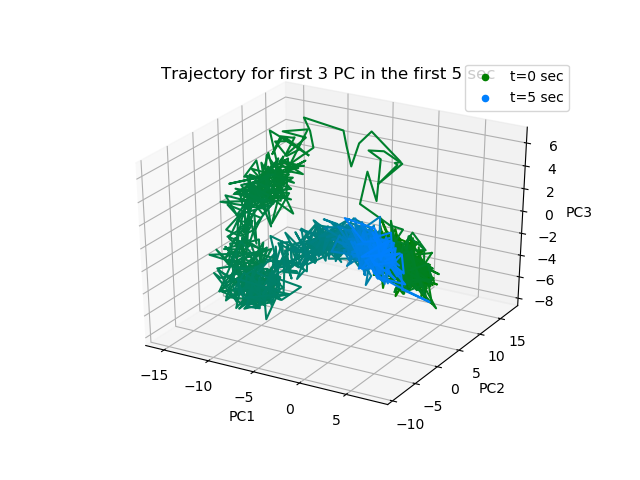

In [32]:
plot_all_PC(data_zscored, t_end=2199)

In [34]:
def Gaussian_smooth(data, a):
    Gau_trial = 0*data 
    t_list = np.arange(data.shape[1])
    
    for i_neuron in range(data.shape[0]):
        for tau in range(data.shape[1]):
            g = np.exp(-a*(t_list-tau)**2)
            Sg = np.multiply(data[i_neuron,:], g)
            Gau_trial[i_neuron, tau] = np.sum(Sg)
            
    return Gau_trial 


def bin_data(data, bin_size):
    data = data.reshape(data.shape[0], -1, bin_size)
    data = np.sum(data, axis=2)
    return data 


In [35]:
Gau_trial = Gaussian_smooth(data_zscored, a=0.05)



ValueError: cannot reshape array of size 617919 into shape (281,newaxis,10)

<IPython.core.display.Javascript object>


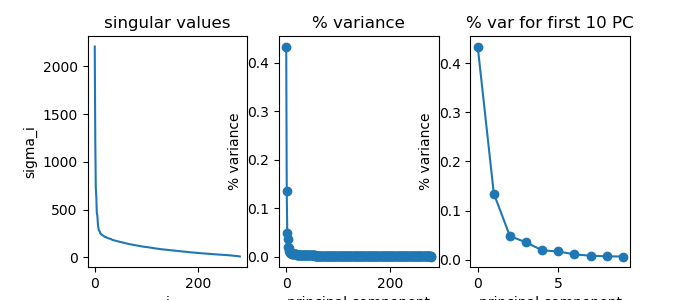

<IPython.core.display.Javascript object>


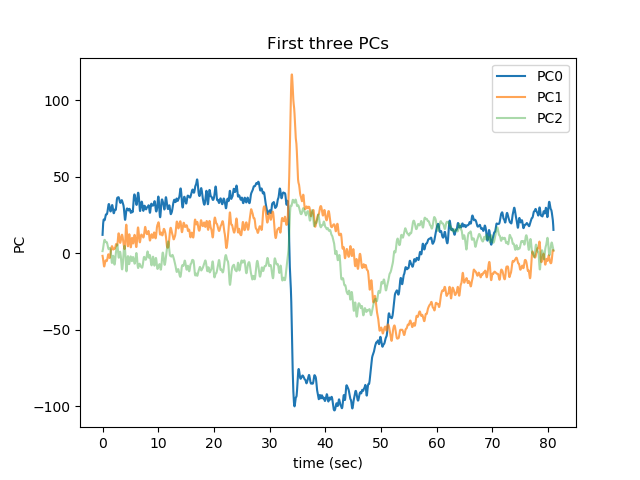

<IPython.core.display.Javascript object>


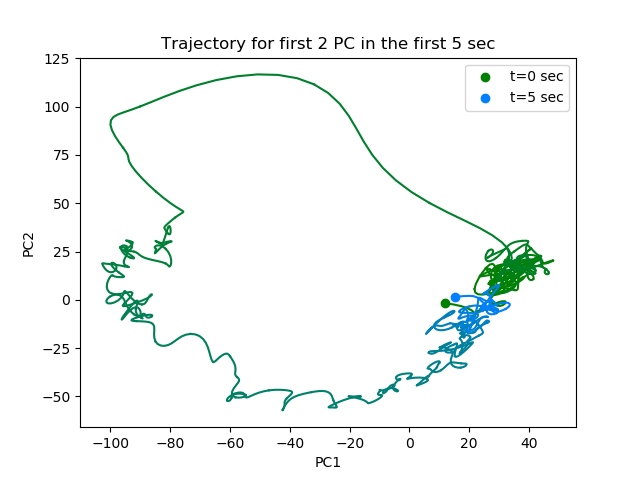

<IPython.core.display.Javascript object>


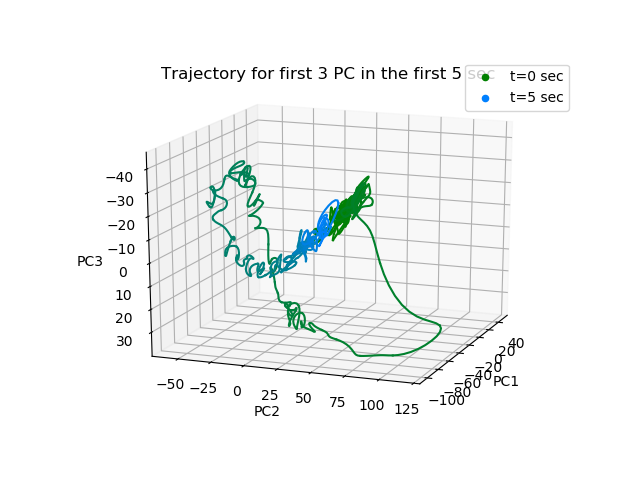

In [36]:
plot_all_PC(Gau_trial, t_end=2199)